<a href="https://colab.research.google.com/github/shrey1234/project_255/blob/main/email_classification_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dependencies

In [1]:
 % pip install polyglot
 % pip install pyicu
 % pip install pycld2
 % pip install nltk
 % pip install tldextract


import nltk
nltk.download('punkt')
from nltk import word_tokenize 
import email
import base64
import os
import re 
import csv
from difflib import SequenceMatcher
import pandas as pd
import quopri as qp
from bs4 import BeautifulSoup
from email.iterators import _structure
from polyglot.detect import Detector
from urllib.parse import urlparse
import tldextract

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounting Drive for data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Functions to parse header,body and url

In [3]:
def parse_url(urls):
    
    ip_address=[];
    len_url=[];
    special_sign_url=[]
    pos_url=[]
    final_url=[]
    subdomain_url=[]
    mail_url = []
    resolve_url = []

    for url in urls:
        #print("Url: ",url)
        #domain of url has ip or not
        try:
            domain =urlparse(url).netloc
            if (domain.replace('.', '').replace(':','').isnumeric()):
                cur_ip=True
            else:
                cur_ip=False
        except:
            print("error occured while parsing domain")
            cur_ip=False
        
        ip_address.append(cur_ip)    
        
        #length of url is 75 or not
        if(len(url)>85):
            cur_len=True
        else:
            cur_len=False
        len_url.append(cur_len)    
        
        #url conatins @ or not
        if "@"  in url: 
            cur_special=True
        else:
            cur_special=False
        special_sign_url.append(cur_special)    
            
        #position of // in url    
        cur_pos=False    
        if "//" in url:    
            res= url.rindex("//") 
            if(res > 7):
                cur_pos=True
            else:
                cur_pos=False  
        pos_url.append(cur_pos)   
        
        #subdomain and multidomain
        domain1=tldextract.extract(url)
        domain1=domain1.domain
        cur_subdomain=False
        if '-' in domain1:
            cur_subdomain=True
        subdomain_url.append(cur_subdomain) 
        
         #mailto function in url
        if "mailto:" in url:
            cur_mail=True
        else:
            cur_mail=False
        mail_url.append(cur_mail) 

         #domain resolve
        try:
            answers = dns.resolver.resolve(domain,'NS')
            cur_resolve=False
        except:
            cur_resolve=True 
    
        resolve_url.append(cur_resolve)
        
    final_url.append(any(ip_address))
    final_url.append(any(len_url))
    final_url.append(any(special_sign_url))
    final_url.append(any(pos_url))
    final_url.append(any(subdomain_url))
    final_url.append(any(mail_url))
    final_url.append(any(resolve_url))

    return final_url

def clean_text(body, debug=False):
    #removing url
    
    #removing urls in text
    body = re.sub('http[s]?://\S+', '', body)
    if debug:
      print(body) 
    #removing punctuations
    body = re.sub(r'[^\w\s]', '', body)
    if debug:
      print(body)
    #removing non latin characters
    body = re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', u'', body)
    #converting to lower case
    body = body.lower()
    
    tokens = word_tokenize(body)
    if debug:
      print(tokens)
   
    return " ".join(tokens)


def parse_emails(folder_path, spam_label, corpus_file = None, csv_file = None):
    key_set = {}
    print("inside parsing emails")
    fields = ['spam', 'subject','sender','reply_to','num_inline_attach', 'num_attachment', 'urls','len_subject','subject_non_ascii','subject_contain_num','num_recipients','sender_replyto_same','header_contentType'
    ,'IP_in_url','Length_of_url','@_in_url','\\\ in url','- in domain_url','mailto: in url','resolver_url','body']
    corpus_fp = None
    if corpus_file is not None:
        #print(corpus_file)
        corpus_fp = open(corpus_file, "w")

    csv_fp = None
    if csv_file is not None:
        #print(csv_file)
        csv_fp = open(csv_file, "w")
    header_written = False
    rows = []
    for dirpath, dirnames, files in os.walk(folder_path, topdown=False):
        for file_name in files:
            print(file_name)
            with open(os.path.join(dirpath, file_name)) as fp:
                try:
                    row = {}
                    urls = {}
                    text_htm = ""
                    text_plain = ""
                    msg = email.message_from_file(fp)
                    num_inline = 0
                    num_attachment = 0
                    non_ascii_regex = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
                    num_regex=re.compile('[0-9]')  

                    for part in msg.walk():
                        if not part.is_multipart():
                            
                            cont_disp = part.get_content_disposition()
                            if cont_disp is not None:
                                #print(f'cont_disp : {cont_disp}')
                                cont_disp_lc = cont_disp.lower()
                                if cont_disp_lc == 'attachment':
                                    num_attachment += 1
                                elif cont_disp_lc == 'inline':
                                    num_inline += 1

                            sub_ct = part.get_content_type().lower()
                            #extracting plain text from html
                            if(sub_ct == 'text/html' or sub_ct == 'text/plain'):
                                pl = part.get_payload()
                                soup = BeautifulSoup(pl, "html.parser")
                                isHtml = bool(soup.find())
                                
                                if isHtml:
                                  text = soup.get_text()
                                  try:
                                      #try to decode quoted printable encoding for both html and text
                                      for link in soup.find_all('a'):
                                        url = link.get('href') 
                                        if url is not None :
                                          url = qp.decodestring(url).decode()
                                          url = url.replace("3D","") 
                                          url = url.replace('"','')
                                          url = url.replace("'","")
                                          urls[url] = urls.get(url, 0) + 1
                                          # print(f'url : {url}')

                                      text_htm += " " + qp.decodestring(text).decode()
                                  except ValueError:
                                      #html does not contain quoted printable encoding
                                      text_htm += " " + text
                                      for link in soup.find_all('a'):
                                        url = link.get('href') 
                                        if url is not None :
                                          url = url.replace("3D","") 
                                          url = url.replace('"','')
                                          url = url.replace("'","")
                                          urls[url] = urls.get(url, 0) + 1
                                          # print(f'url (exception): {url}')
                                else:
                                  text_plain += " " + part.get_payload()
                            else :
                                pass
                    

                    #finding all url in plain text and plain text extracted from html
                    for url in re.findall('http[s]?://\S+', text_plain + " " + text_htm):
                        urls[url] = urls.get(url, 0) + 1
                        # print(f'plain text url : {url}')
                    #cleaning text
                    text_plain = clean_text(text_plain)
                    text_htm = clean_text(text_htm)
                    # checking if both text are same (discard html if its same as plain text, choosing cutoff at 85%)
                    seq = SequenceMatcher(None, text_plain, text_htm)
                    seq_ratio = seq.ratio()
                    # print(f"seq ratio : {seq_ratio}")
                    body = ""
                    if(seq_ratio > 0.85):
                        body += text_plain
                    else :
                        body += text_plain + " " + text_htm

                    if body is not None:
                       #print(len(body))
                       length_b=len(body)
                       row[fields[20]] = length_b
                       #print()

                    if corpus_fp is not None:
                        corpus_fp.write(body + "\n")
                        corpus_fp.flush()
                    
                    #writing to csv
                    if csv_fp is not None:

                        row[fields[0]] = spam_label
                        subj = msg.get('subject', None)
                        if subj is None:
                            subj = msg.get('SUBJECT', None)
                        if subj is None:
                            subj = msg.get('Subject', "")

                        row[fields[1]] = subj
                        sender = msg.get('From', None)
                        if sender is None:
                            sender = msg.get('FROM', None)
                        if sender is None:
                            sender = msg.get('from', None)

                        row[fields[2]] = " ".join(re.findall('[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', sender)) if sender is not None else sender

                        replyTo = None
                        replyTo = msg.get('Reply-To', None)
                        if replyTo is None:
                            replyTo = msg.get('Reply-to', None)
                        if replyTo is None:
                            replyTo = msg.get('Replyto', None)
                        if replyTo is None:
                            replyTo = msg.get('reply-to', None)
                        # print(replyTo)

                        row[fields[3]] = " ".join(re.findall('[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', replyTo)) if replyTo is not None else replyTo

                        row[fields[4]] = num_inline
                        row[fields[5]] = num_attachment
                        keys = urls.keys()
                        if len(keys) > 0:
                            final_url=parse_url(keys)
                            #print("inside",final_url)
                            row[fields[6]] = " ".join(keys) if len(keys) > 0 else None
                            row[fields[13]] = final_url[0]
                            row[fields[14]] = final_url[1]
                            row[fields[15]] = final_url[2]
                            row[fields[16]] = final_url[3]
                            row[fields[17]] = final_url[4]
                            row[fields[18]] = final_url[5]
                            row[fields[19]] = final_url[6]


                        row[fields[7]] = len(subj)
                        if non_ascii_regex.search(subj) is  None:
                             row[fields[8]] = False
                        else:
                             row[fields[8]] = True
                        if num_regex.search(subj) is None:
                             row[fields[9]] = False
                        else:
                             row[fields[9]] = True  
                        
                        recipients=msg.get('To',None)
                        recipients_array=None
                        if recipients is None:
                            row[fields[10]]=0
                        else:
                            recipients_array=recipients.split(',')
                            row[fields[10]]=len(recipients_array)

                        if sender == replyTo:
                            sender_replyto_same=True
                        else:
                            sender_replyto_same=False

                        row[fields[11]]=sender_replyto_same
                        contentType=None
                        if contentType is None:
                            contentType=msg.get('Content-Type',None)
                        if contentType is None:
                            contentType=msg.get('Content-type',None)
                        if contentType is not None:  
                          if ';' in contentType:
                            contentType=contentType.split(';')[0]    
                        #print(contentType)    
                        row[fields[12]]=contentType
                        rows.append(row)

                except UnicodeDecodeError:
                    pass  
    
    if corpus_fp is not None:
        corpus_fp.close()

    if csv_fp is not None:
        csvwriter = csv.DictWriter(csv_fp, fieldnames = fields)
        if not header_written:
          csvwriter.writeheader()
          # writing the fields  
          csvwriter.writerows(rows)
        csv_fp.close() 

    print(key_set)    

CSV for Ham Emails

In [ ]:

parse_emails('/content/drive/MyDrive/hard_ham_eml', 0, csv_file='email_data_eh.csv')
parse_emails('/content/drive/MyDrive/easy_ham_eml', 0, csv_file='email_data_eh.csv')


inside parsing emails
This_week_Deck_Tex_Edit_Plu.eml
Reg_Headlines_Wednesday_Jul.eml
_Lockergnome_Penguin_Shell_.eml
CNET_NEWS_COM_Cable_compani.eml
_Lockergnome_Windows_Daily_.eml
Xscale_disappoints_in_Toshi.eml
Save_an_extra_50_on_the_iPa.eml
_Lockergnome_Tech_Specialis.eml
CNET_NEWS_COM_The_tech_side.eml
This_week_Browse_or_bust.eml
_Lockergnome_Apple_Core_Ski.eml
MS_s_Palladium_What_the_hel.eml
Looking_for_the_perfect_cam.eml
Your_Daily_Dilbert_07_10_20.eml
What_to_look_for_in_your_ne.eml
NEWS_COM_INVESTOR_Tech_stoc.eml
Next_MS_Office_Here_s_what_.eml
_Lockergnome_Windows_Da0001.eml
This_Week_FileSystem_Applet.eml
Shop_smarter_with_ZDNet_s_p.eml
Intel_900MHz_256MB_PC_133_1.eml
CNET_NEWS_CONTEXT_Hollywood.eml
IBM_s_thin_ThinkPads_fit_to.eml
Get_the_Perfect_Mix_of_ZDNe.eml
Reg_Headlines_Thursday_July.eml
Great_deals_on_perfect_Summ.eml
Cell_phones_coming_soon.eml
CNET_NEWS_COM_Copies_Webcas.eml
CNET_Why_I_don_t_use_firewa.eml
CNET_Cool_Gear_Leica_s_lege.eml
Moore_Speech_recognition_

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Re_A_moment_of_silence_0007.eml
Re_4_A_moment_of_silence_fo.eml
Re_A_moment_of_silence_0006.eml
Re_2_A_moment_of_silence_fo.eml
MIT_OpenCourseWare.eml
Re_A_moment_of_silence_0001.eml
NYTimes_com_Article_Vast_De.eml
Re_Re_4_A_moment_of_silence.eml
Re_A_moment_of_silence_for_.eml
Dinosaurs_Eggs_and_the_Orig.eml
Re_A_moment_of_silence_0010.eml
Re_EBusiness_Webforms_c0007.eml
RE_MIT_OpenCourseWare0001.eml
Am_I_This_Or_Not_.eml
Re_MIT_OpenCourseWare.eml
Re_Dinosaurs_Eggs_and_the_O.eml
RE_Re_4_A_moment_of_sil0001.eml
Re_6_A_moment_of_silence_fo.eml
If_you_like_graphic_novels_.eml
Re_The_Wrong_Business.eml
Internet_Archive_bookmobile.eml
Re_A_moment_of_silence_0008.eml
Re_A_moment_of_silence_0009.eml
Re_Internet_Archive_bookmob.eml
no_subject000006.eml
Re_Optical_analog_compu0004.eml
Polit_spam.eml
Re_Optical_analog_compu0002.eml
Re_ActiveBuddy0007.eml
Creative_political_speech.eml
Re_Optical_analog_computing.eml
Re_Polit_spam.eml
Re_Wifi_query.eml
Re_ActiveBuddy0006.eml
Re_Wifi_query0002.eml

# CSV for Spam Emails


In [ ]:

parse_emails('/content/drive/MyDrive/spam2_ham_eml', 1, csv_file='email_data_sp.csv')

inside parsing emails
Start_now_look_great_this_s.eml
MCLE_Seminars.eml
ADV_Affordable_Life_Insuran.eml
Re_RFTMBSWFN.eml
cc_Prevents_diesel_fuel_gel.eml
ADV_Extended_Auto_Warra0002.eml
judicial_judgments_child_su.eml
hello0001.eml
Candidate_update_21_05_02.eml
BIZ_INFO_COM_for_only_14_95.eml
6_25_30_yr_fixed_No_points_.eml
WHAT_HAPPENED_TO_YOU_982244.eml
_iso_8859_1_Q_Fw_CD_Nua_do_.eml
Government_Guarantees_Your_.eml
FREE_ALL_NATURAL_SEXUAL_STI.eml
Turn_5_into_20k_Pay_Pal_vdb.eml
Swiss_Iinternet_account0001.eml
Hey_.eml
please_help_new_webcam_mode.eml
Feel_The_Power_.eml
want_to_accept_credit_cards.eml
_500_000_Life_Policy_9_50_p.eml
Great_Idea_for_You_byrdshot.eml
Secretly_Record_all_int0001.eml
3D_Motion_Capture0001.eml
ADV_Life_Insurance_Penn0001.eml
Brad_Pitt_Caught_Naked_With.eml
BULKER_CD_BULKER_CD_.eml
Roth_conversions_jumbo_annu.eml
Attention_Instant_Internet_.eml
Super_credit_repair_program.eml
6_25_30_yr_fixed_No_poi0001.eml
Helpful_Septic_Tank_Informa.eml
Almost_Guaranteed_I

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.rebackee.com/cursos2/contraloria.htm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Is_Your_Mortgage_Payment_to.eml
_big5_Q_B4M_A7_E4_BE_F7_B7_.eml
LOOKING_FOR_LEADERS_IN_YOUR.eml
Great_prices_on_laser_toner.eml
Re_Instant_Quote.eml
You_re_Invited_.eml
_SA_EM1_Aren_t_we_accorded_.eml
_Mortgage_Approved_0002.eml
Fw_The_Gold_Buddha.eml
96_Of_Our_Customers_Increas.eml
Easy_Summer_Income.eml
Let_get_together_when_you_g.eml
Best_50_I_ever_spent_.eml
_SA_Chuong_trinh_khuyen_mai.eml
Save_30k_even_if_you_ve_ref.eml
Toners_and_inkjet_cartr0002.eml
Repair_your_credit_right_on.eml
Jm_be_your_own_private_0001.eml
_CLICK_HERE_How_to_legally_.eml
Online_Credit_Repair_Approv.eml
21st_Century_Web_Specialist.eml
Toners_and_inkjet_cartr0003.eml
ADV_Interest_rates_are_DOWN.eml
_ILUG_Social_We_want_to_tra.eml
Your_Paycheck_.eml
We_ll_show_you_how_to_get_i.eml
Debt_Consolidation.eml
eBay_and_Auction_Info_30314.eml
RE_Public_Notice_Immune_Sup.eml
compare_mortgage_rate_YLON.eml
_Fast_Acting_Viagra.eml
_ILUG_BNIMANIE_.eml
The_database_that_Bill_Gate.eml
Lose_16_Pounds_In_10_Days_G.eml
67_of_

## Email Content Types
- multipart/alternative (same email content from poor format (like text) to rich format(eg html) in multiple parts)
- multipart/mixed (with attachments)
- multipart/related (embedded images with text like base64 img etc)
- multipart/signed ()
- multipart/report
- text/plain
- text/html



In [4]:
df_spam = pd.read_csv('email_data_sp.csv')
#display(df_spam)
df_spam.describe()

,spam,num_inline_attach,num_attachment,len_subject,num_recipients,body
count,1276.0,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000
mean,1.0,0.026646,0.005486,40.219436,2.085423,2099.449060
std,0.0,0.161109,0.073892,20.571302,9.733375,4903.755892
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,27.000000,1.000000,601.000000
50%,1.0,0.000000,0.000000,38.000000,1.000000,971.500000
75%,1.0,0.000000,0.000000,52.000000,1.000000,1861.000000
max,1.0,1.000000,1.000000,242.000000,318.000000,110600.000000


In [5]:
df_ham = pd.read_csv('email_data_eh.csv')
#display(df_ham)
df_ham.describe()

,spam,num_inline_attach,num_attachment,len_subject,num_recipients,body
count,2428.0,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000
mean,0.0,0.077430,0.002883,36.160626,1.004530,1037.330313
std,0.0,0.311464,0.053627,18.838758,0.473853,2624.107536
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,23.000000,1.000000,313.000000
50%,0.0,0.000000,0.000000,33.000000,1.000000,656.000000
75%,0.0,0.000000,0.000000,46.000000,1.000000,1178.000000
max,0.0,2.000000,1.000000,152.000000,7.000000,82507.000000


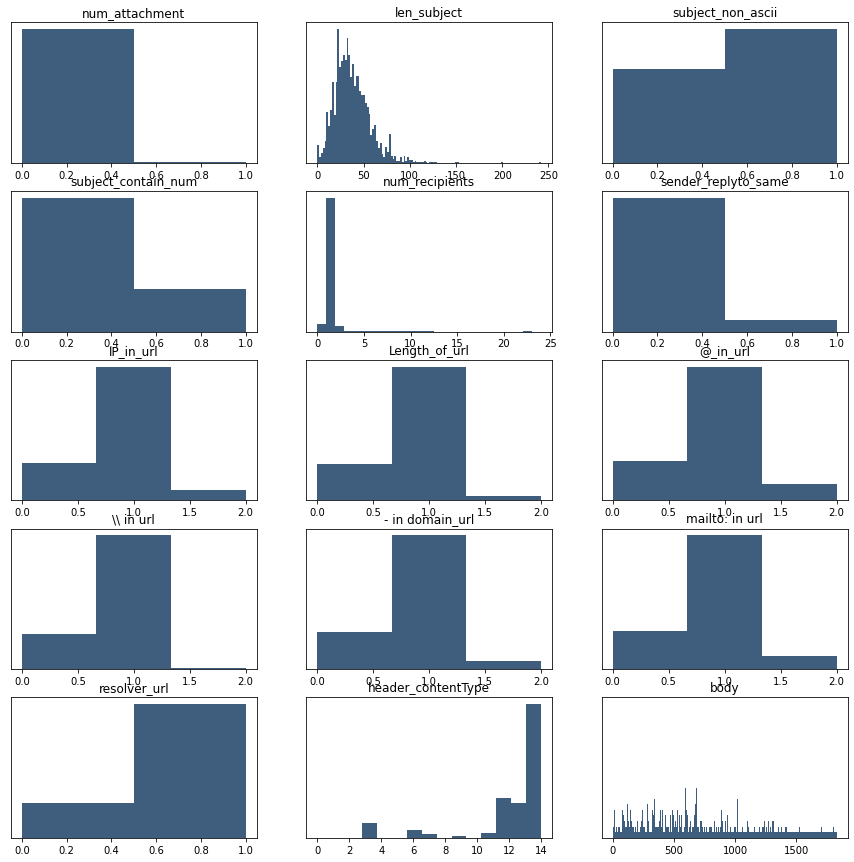

In [6]:
import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

l = preprocessing.LabelEncoder()
df=df_ham.append(df_spam)
df['subject_non_ascii']=l.fit_transform(df['subject_non_ascii'])
df['subject_contain_num']=l.fit_transform(df['subject_contain_num'])
df['num_recipients']=l.fit_transform(df['num_recipients'])
df['sender_replyto_same']=l.fit_transform(df['sender_replyto_same'])
df['Length_of_url']=l.fit_transform(df['Length_of_url'])
df['IP_in_url']=l.fit_transform(df['IP_in_url'])
df['@_in_url']=l.fit_transform(df['@_in_url'])
df['\\\ in url']=l.fit_transform(df['\\\ in url'])
df['- in domain_url']=l.fit_transform(df['- in domain_url'])
df['mailto: in url']=l.fit_transform(df['mailto: in url'])
df['resolver_url']=l.fit_transform(df['resolver_url'])
df['header_contentType']=l.fit_transform(df['header_contentType'].astype(str))
df['body']=l.fit_transform(df['body'])

new1=df[['num_inline_attach', 'num_attachment','len_subject','subject_non_ascii','subject_contain_num','num_recipients','sender_replyto_same'
    ,'IP_in_url','Length_of_url','@_in_url','\\\ in url','- in domain_url','mailto: in url','resolver_url','header_contentType','body']]

fig = plt.figure(figsize=(15, 15))

for i in range(1, new1.shape[1]):
    plt.subplot(5, 3, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(new1.columns.values[i])
    vals = np.size(new1.iloc[:, i].unique())
    plt.hist(new1.iloc[:, i], bins=vals, color='#3F5D7D')

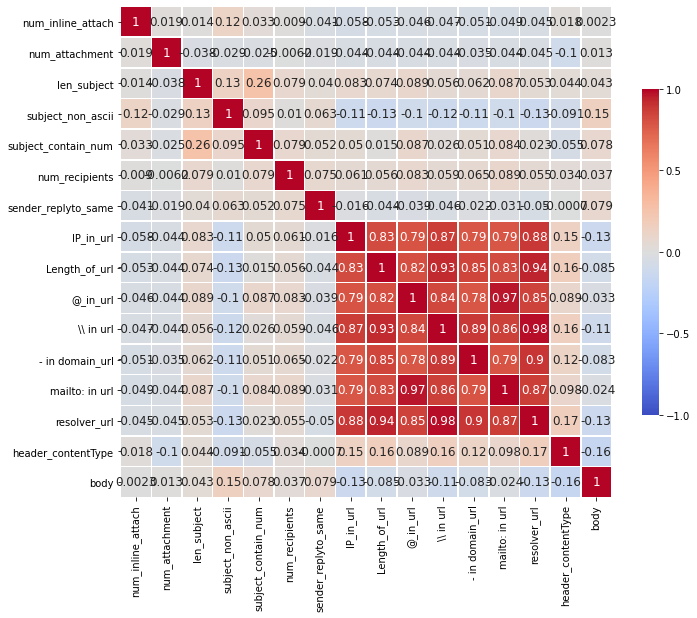

In [7]:
import seaborn as sns

corr_matrix = new1.corr()
#corr_matrix
f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Missing values


*  Email without URL should be given 'NO URL' value for URL 
*  If there is no URL in the email , attribute related to URL's value is considered 'False' i.e. legitimate

attribute

In [8]:

#df["urls"].fillna("No URL", inplace = True)
#df[['IP_in_url','Length_of_url','@_in_url','\\\ in url','- in domain_url','mailto: in url','resolver_url']].fillna(False,inplace=True)
data =df[['spam','num_inline_attach', 'num_attachment','len_subject','subject_non_ascii','subject_contain_num','num_recipients','sender_replyto_same'
    ,'IP_in_url','Length_of_url','@_in_url','\\\ in url','- in domain_url','mailto: in url','resolver_url','header_contentType','body']]
#data.dropna()
#X=df[['num_inline_attach', 'num_attachment','len_subject','subject_non_ascii','subject_contain_num','num_recipients','sender_replyto_same'
#    ,'IP_in_url','Length_of_url','@_in_url','\\\ in url','- in domain_url','mailto: in url','resolver_url']]

X=df[['num_inline_attach', 'num_attachment','len_subject','subject_non_ascii','subject_contain_num','num_recipients','sender_replyto_same'
    ,'IP_in_url','Length_of_url','@_in_url','\\\ in url','- in domain_url','mailto: in url','header_contentType','body']]

   
y=df[['spam']]
print(X.shape)
print(y.shape)
X

(3704, 15)
(3704, 1)


,num_inline_attach,num_attachment,len_subject,subject_non_ascii,subject_contain_num,num_recipients,sender_replyto_same,IP_in_url,Length_of_url,@_in_url,\\ in url,- in domain_url,mailto: in url,header_contentType,body
0,2,0,51,1,0,1,0,0,0,0,0,0,0,11,1363
1,2,0,39,1,1,1,0,0,0,0,0,0,0,11,765
2,0,0,53,1,0,1,0,1,1,1,1,1,1,14,523
3,0,0,46,0,0,1,0,1,1,1,1,1,1,14,261
4,2,0,53,1,0,1,0,0,0,0,0,0,0,11,1277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,0,0,59,0,0,1,0,2,1,1,1,1,1,14,255
1272,0,0,33,0,0,1,0,1,1,2,1,1,2,6,1541
1273,0,0,23,0,0,1,0,1,1,1,1,1,1,14,1273
1274,0,0,43,0,1,1,0,1,1,1,1,2,1,13,128


In [9]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Accuracy: 0.8084532374100719
F1 score: 0.6787330316742082
Precision: 0.8653846153846154
recall: 0.5583126550868487
AUC: 0.84
fpr:  0.3356800777732622
tpr:  0.7362156706060479


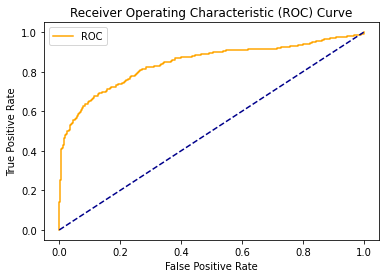

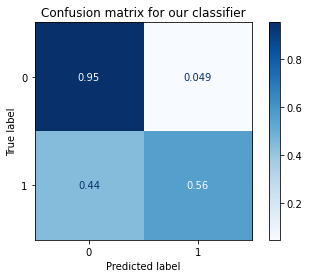

In [10]:
#Logistic regression model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix


X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=101)

logisticRegr = LogisticRegression(max_iter=7600)
logisticRegr.fit(X_train, y_train.values.ravel())
y_pred = logisticRegr.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("recall:",metrics.recall_score(y_test, y_pred))

probs = logisticRegr.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
print("fpr: ",mean(fpr))
print("tpr: ",mean(tpr))
plot_roc_curve(fpr, tpr)
matrix = plot_confusion_matrix(logisticRegr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

In [ ]:
#SVM model
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix


clf = svm.SVC(kernel='linear',probability=True) 
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

probs = clf.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
print("fpr: ",mean(fpr))
print("tpr: ",mean(tpr))
plot_roc_curve(fpr, tpr)
#matrix = plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,normalize='true')
#plt.title('Confusion matrix for our classifier')
#plt.show(matrix)
#plt.show()

Accuracy: 0.7840755735492577
F1 score: 0.6172248803827751
Precision: 0.8269230769230769
recall: 0.49236641221374045
AUC: 0.82
fpr:  0.32819751893579946
tpr:  0.6941754463440792


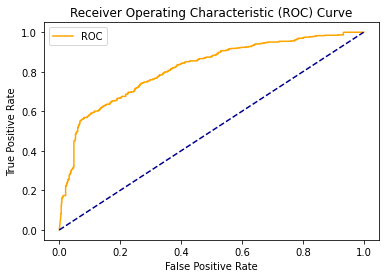

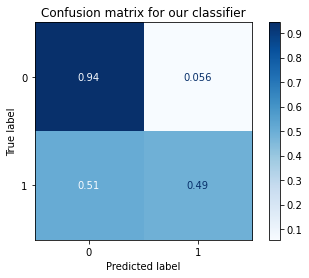

In [24]:
#naive bayes model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=109) 
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
y_pred = gnb.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("recall:",metrics.recall_score(y_test, y_pred))

probs = gnb.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
print("fpr: ",mean(fpr))
print("tpr: ",mean(tpr))
plot_roc_curve(fpr, tpr)
matrix = plot_confusion_matrix(gnb, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

Accuracy: 0.8616734143049932
F1 score: 0.7922998986828774
Precision: 0.8444924406047516
Recall: 0.7461832061068703
AUC: 0.91
fpr:  0.22472412764688338
tpr:  0.661123227917121


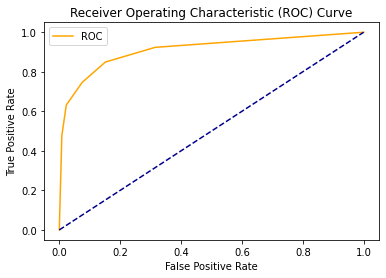

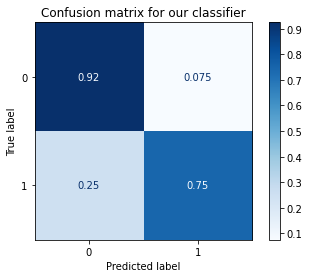

In [23]:
#KNN model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train.values.ravel())
y_pred = classifier.predict(X_test)
classifier.score(X_test, y_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
print("fpr: ",mean(fpr))
print("tpr: ",mean(tpr))
plot_roc_curve(fpr, tpr)
matrix = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

Accuracy: 0.9352226720647774
F1 score: 0.905511811023622
Precision: 0.9349593495934959
Recall: 0.8778625954198473
AUC: 0.96
fpr:  0.10867666482041669
tpr:  0.8038440567066522


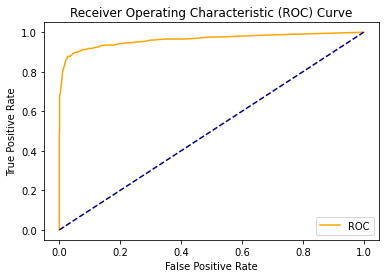

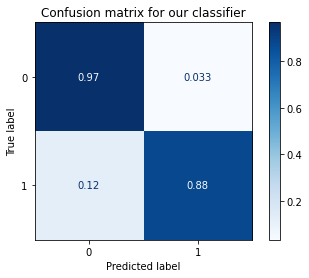

In [22]:
# Random forest classifier

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix


clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train.values.ravel())
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

probs = clf.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
print("fpr: ",mean(fpr))
print("tpr: ",mean(tpr))
plot_roc_curve(fpr, tpr)
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

No handles with labels found to put in legend.


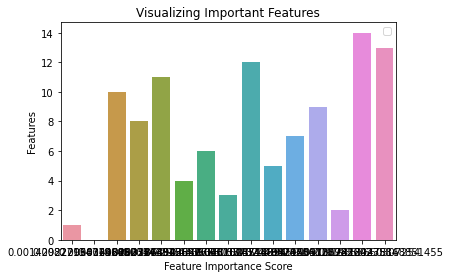

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
feature_imp
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()